### BDP Final Project

#### Nikhil Joshi

In [1]:
#Ensure we are using the right kernel
print (sc.version)

3.0.1


In [2]:
# Date notebook was last run
import datetime
import pytz

datetime.datetime.now(pytz.timezone('US/Central')).strftime("%a, %d %B %Y %H:%M:%S")

'Thu, 18 March 2021 15:01:23'

In [1]:
# Environment
from google.cloud import storage
import io
import os
import subprocess
import shutil
warnings.filterwarnings(action='ignore')

from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType
import pandas as pd
import re
import json
from itertools import combinations, takewhile
import collections

# Data analysis and visualization
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from itertools import compress 
import seaborn as sns
import matplotlib.pyplot as plt

# Data selection and transformation
from pyspark.sql import Row
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import SQLContext
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
spark.conf.set("spark.sql.execution.arrow.enabled", "true")
spark.conf.set("spark.sql.crossJoin.enabled", "true")
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

### Pulling the Tweets

In [4]:
path = 'gs://msca-bdp-tweets/Tweets/*.json'

In [ ]:
#SAMPLE
%time tweets_df = spark.read.json(path)

CPU times: user 330 ms, sys: 107 ms, total: 437 ms
Wall time: 27min 3s


In [10]:
tweets_df.printSchema()

root
 |-- contributors: string (nullable = true)
 |-- coordinates: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- display_text_range: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- entities: struct (nullable = true)
 |    |-- hashtags: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: long (containsNull = true)
 |    |    |    |-- text: string (nullable = true)
 |    |-- media: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- additional_media_info: struct (nullable = true)
 |    |    |    |    |-- description: string (nullable = true)
 |    |    |    |    |-- embeddable: boolean (nullable = true)
 |    |    |    |    |-- monetizable: bo

In [ ]:
tweets_df.limit(3)

contributors,coordinates,created_at,display_text_range,entities,extended_entities,extended_tweet,favorite_count,favorited,filter_level,geo,id,id_str,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,is_quote_status,lang,limit,place,possibly_sensitive,quote_count,quoted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,reply_count,retweet_count,retweeted,retweeted_status,scopes,source,text,timestamp_ms,truncated,user,withheld_copyright,withheld_in_countries
null,null,Sat Mar 31 22:14:...,null,"[[[[22, 32], Fina...",null,null,0,false,low,null,980206648336834561,980206648336834561,null,null,null,null,null,false,en,null,null,null,0,null,null,null,null,0,0,false,null,null,"<a href=""http://t...",Color on color in...,1522534450979,false,"[false, Wed Nov 0...",null,null
null,null,Sat Mar 31 22:14:...,null,"[[],, [], [], []]",null,null,0,false,low,null,980206648454246401,980206648454246401,null,null,null,null,null,false,en,null,null,null,0,null,null,null,null,0,0,false,null,null,"<a href=""http://t...",Great sign in loy...,1522534451007,false,"[false, Mon May 1...",null,null
null,null,Sat Mar 31 22:14:...,null,"[[[[54, 63], Boil...","[[[,, pic.twitter...",null,0,false,low,null,980206648110219264,980206648110219264,null,null,null,null,null,false,en,null,null,false,0,null,null,null,null,0,0,false,"[,, Sat Mar 31 20...",null,"<a href=""http://t...",RT @willc413: Had...,1522534450925,false,"[false, Fri Jan 2...",null,null


### Keeping the selected Columns or Features

There are many columns present in the data. However, selecting only the interested columns for further analysis.

In [7]:
#Viewing the selected column
tweets_df.select("user.id", "text", "retweeted_status.retweet_count", "retweeted_status.retweeted", "user.screen_name", "user.followers_count", "user.location", "created_at").limit(5).toPandas()

,id,text,retweet_count,retweeted,screen_name,followers_count,location,created_at
0,327074429,"RT @BigHPrivateEye: a lot of people don't know this but while Obama was in office he started the ""my brothers keeper"" program which was a m…",66845.0,False,Karenldub,1761,Oceanside Ca.,Thu Apr 26 15:15:01 +0000 2018
1,778583444385255425,"RT @dailyunnie: West Coast:\nLA, 3 days\nOakland, 1 day\n\nEast Coast:\nNewark, 2 days\n\nSouth Central:\nFort Worth, 2 days\n\nMidwest:\nChicago, 2 d…",28.0,False,Topspace97,38,Thailand,Thu Apr 26 15:15:01 +0000 2018
2,1703713135,I’m gonna try Chicago or Newark!!!!! @BTS_twt #BTSWorldTour https://t.co/McU7hn56Kd,NaN,None,melodymae333,129,United States,Thu Apr 26 15:15:01 +0000 2018
3,183379870,"RT @BigHPrivateEye: a lot of people don't know this but while Obama was in office he started the ""my brothers keeper"" program which was a m…",66847.0,False,Fernunny,8,None,Thu Apr 26 15:15:02 +0000 2018
4,22164019,"Howard University Stares Down Challenges, and Hard Questions on Black Colleges https://t.co/w54bSVxIPd",NaN,None,vtblom,1070,"West Melbourne, FL",Thu Apr 26 15:15:02 +0000 2018


In [8]:
#Passing the selected column to a new dataframe
tweets_new_df = tweets_df.select("user.id", "text", "retweeted_status.retweet_count", "retweeted_status.retweeted", "user.screen_name", "user.followers_count", "user.location", "created_at")

Making the changes in retweeted column. Mentioning True against the record where retweet count is greater than 0 and False where retweet count is nan.

In [9]:
tweets_new_df = tweets_new_df.withColumn("retweeted", when((col("retweeted")==False), True).otherwise(False))

In [16]:
tweets_new_df.limit(5)

id,text,retweet_count,retweeted,screen_name,followers_count,location,created_at
764795946,RT @PeterAskin1: ...,43,true,NadineHarris12,369,"London, England",Mon Oct 29 12:15:...
485939082,RT @TheAtlantic: ...,15,true,Setemi_Oni,479,null,Mon Oct 29 12:15:...
2315320188,Budget supermarke...,null,false,streetspaceUK,216,"Hythe, England",Mon Oct 29 12:15:...
978104049949167616,RT @alezander: Jo...,37244,true,typicallyshook_,120,null,Mon Oct 29 12:15:...
4392465563,RT @smooyacs: ★ K...,661,true,callumjones2011,49,null,Mon Oct 29 12:15:...


Removing the records of the employees where location is null and substituting the value 0 where retweet count is null

In [10]:
tweets_new_df = tweets_new_df.filter("location is not NULL").withColumn("retweet_count", when((col("retweet_count").isNull()), 0).otherwise(col("retweet_count")))

In [ ]:
tweets_new_df.limit(3)

id,text,retweet_count,retweeted,screen_name,followers_count,location,created_at
108358699,RT @TheRealSanB: ...,7,true,Itsjustindi,3780,Miner Hall💚💕,Tue Apr 14 03:14:...
1094084892164583425,Harvard Universit...,0,false,fizzyteacher732,95,Nowhere usa,Tue Apr 14 03:14:...
4029878172,RT @chuckietoyou:...,1890,true,vvillievvill,682,"Atlanta, GA",Tue Apr 14 03:14:...


### Identify tweets related to UChicago and 3-4 universities of your choice

- Choose universities with sufficient twitter activity  

### Discard irrelevant tweets  

- Will be 95%+ of the data

#### Filtering the selected universities  
I have selected 4 universities in total based on web search on google as who are the most active universities on twitter. Based on my result I have finalized **Harvard University, Stanford University and Yale** in addition to **University of Chicago** 

In [11]:
# Filttering the texts for UChicago, Stanford, Yale and Harvard
tweets_university = tweets_new_df.filter(lower(col('text')).contains('uchicago') |
                                               lower(col('text')).contains('UChicago') |
                                               lower(col('text')).contains('university of chicago') |
                                               lower(col('text')).contains('University of Chicago') |
                                               lower(col('text')).contains('uchicago booth school of business') |
                                               lower(col('text')).contains('uofc') |
                                               lower(col('text')).contains('stanford university') |
                                               lower(col('text')).contains('Stanford University') |
                                               lower(col('text')).contains('stanford') |
                                               lower(col('text')).contains('yale') |
                                               lower(col('text')).contains('elis') |
                                               lower(col('text')).contains('harvard') |
                                               lower(col('text')).contains('Harvard') |
                                               lower(col('text')).contains('harvard university') |
                                               lower(col('text')).contains('Harvard University'))

In [12]:
# Filtering tweets which contains other information and not about University

tweets_nonuniversity = tweets_new_df.filter(~lower(col('text')).contains('university') & 
                                            ~lower(col('text')).contains('uchicago') &
                                            ~lower(col('text')).contains('stanford') &
                                            ~lower(col('text')).contains('yale') &
                                            ~lower(col('text')).contains('harvard'))

### Seperating UChicago Tweets

In [13]:
# storing UChicago tweets in a df
Uchicago_tweets = tweets_university.filter(lower(col('text')).contains('uchicago') |
                                                 lower(col('text')).contains('UChicago') |
                                                 lower(col('text')).contains('university of chicago') |
                                                 lower(col('text')).contains('University of Chicago') |
                                                 lower(col('text')).contains('uchicago booth school of business') |
                                                 lower(col('text')).contains('uofc'))

### Seperating Stanford Tweets

In [14]:
# storing Stanford tweets in a df
stanford_tweets = tweets_university.filter(lower(col('text')).contains('stanford') |
                                                 lower(col('text')).contains('stanford university') |
                                                 lower(col('text')).contains('stanford'))

### Seperating Yale Tweets

In [15]:
# storing Yale tweets in a df
yale_tweets = tweets_university.filter(lower(col('text')).contains('yale') |
                                       lower(col('text')).contains('elis'))

### Seperating Harvard Tweets

In [16]:
# storing Harvard tweets in a df
harvard_tweets = tweets_university.filter(lower(col('text')).contains('harvard') |
                                               lower(col('text')).contains('Harvard') |
                                               lower(col('text')).contains('harvard university') |
                                               lower(col('text')).contains('Harvard University'))

## Complete thorough EDA to identify which variables you can use to profile the Twitterers

- A lot of variables are poorly populated and will have to be discarded

In [17]:
# Viewing the columns present in the university tweet df
tweets_university.columns

['id',
 'text',
 'retweet_count',
 'retweeted',
 'screen_name',
 'followers_count',
 'location',
 'created_at']

In [42]:
tweets_nonuniversity.columns

['id',
 'text',
 'retweet_count',
 'retweeted',
 'screen_name',
 'followers_count',
 'location',
 'created_at']

In [ ]:
tweets_university.limit(5)

id,text,retweet_count,retweeted,screen_name,followers_count,location,created_at
101662924,Touchdown #Stanfo...,0,false,donkanyc,36,"Stanford, CA",Sun Nov 19 02:15:...
43431279,Gateway to #Wisdo...,0,false,djjonesjr,336,"White Plains, NY",Sun Nov 19 02:15:...
929546101417418753,RT @MegaTamil: Do...,4,true,prasannaayya,3,"Bodi,india",Sun Nov 19 02:17:...
783302592134782978,RT @Harvard: Univ...,27,true,itsjustinsabir,139,"Kolkata, India",Sun Nov 19 02:19:...
47814888,@Nicole_Cliffe @e...,0,false,katamaridarcy,129,"Chicago, IL",Sun Nov 19 02:20:...


In [ ]:
tweets_university.filter('retweet_count!=0').count()

3896700

In [ ]:
tweets_university.filter('retweeted!="false"').count()

In [ ]:
tweets_university.filter('followers_count==0').count()

## Identify the most prolific / influential Twitterers

- By message volume
- By message retweet
- How much are they tweeting about the Universities vs. other topics?

**1) By Message Volume**

In [15]:
# Selecting top 5 prolific / influential twitteres tweeting regarding university
univ_prolific_users = tweets_university.groupBy(['id','screen_name']).agg(count('id').\
                                               alias('original_tweet_count_univ')).\
                                               orderBy('original_tweet_count_univ',ascending=False).limit(5)

In [ ]:
univ_prolific_users

id,screen_name,original_tweet_count_univ
730577022120919041,stickerladysv,7938
2821421079,kinibottommintd,5642
922789731049521158,ITProfess_Actor,4419
131144285,UChicago,3471
20270494,ChicagoMaroons,3318


We can see from the above output twitterer **stickerladysv** is the one who is tweeting the most in terms of volume about the university.

**2) By Message retweet**

In [40]:
#Selecting top 5 prolific/ influential twitters whose tweet has tweeted maximum times
univ_prolific_users_new = tweets_university.groupBy(['id','screen_name']).agg(count('retweet_count').\
                                               alias('retweet_count')).\
                                               orderBy('retweet_count',ascending=False).limit(5)

In [ ]:
univ_prolific_users_new

id,screen_name,retweet_count
730577022120919041,stickerladysv,7938
2821421079,kinibottommintd,5642
922789731049521158,ITProfess_Actor,4419
131144285,UChicago,3471
20270494,ChicagoMaroons,3318


From above results we can see that user **stickerladysv** is the one who also has the most retweet count

**3) Tweeting about the Universities vs. other topics**

In [ ]:
tweets_nonuniversity.filter(col('id').contains('730577022120919041')).\
groupBy(['id','screen_name']).agg(count('id').\
alias('other_topics_tweet_count'))

id,screen_name,other_topics_tweet_count
730577022120919041,stickerladysv,15


## Where are these Twitterers located?

- For UChicago
- For other universities
- Do you see any relationship between university locations and Twitterers’ locations?
- Visualize the relationships

**1) UChicago**

In [ ]:
# Selecting top 5 twitterer location 
uchicago_twitterer_loc = Uchicago_tweets.filter(col('location').isNotNull()).\
groupBy(['location']).\
agg(count('id').alias('UChicago_total_twitterer_located')).\
orderBy('UChicago_total_twitterer_located',ascending=False).limit(5).toPandas()

In [ ]:
uchicago_twitterer_loc

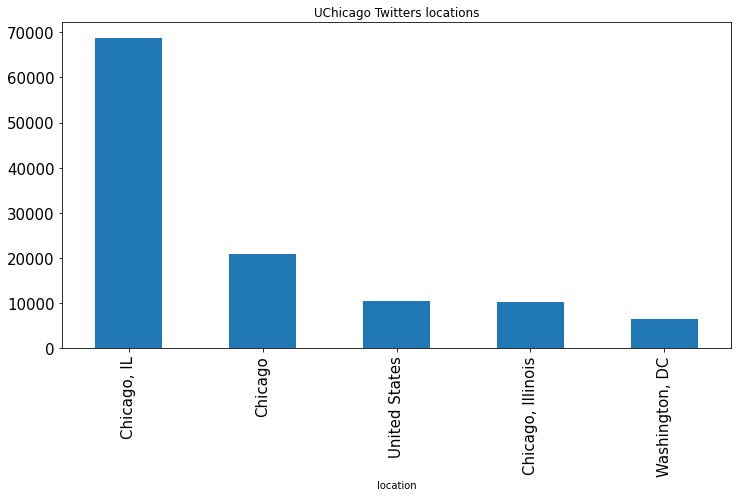

In [ ]:
#Lets try to visualize the twitterers location who is tweeting about UChicago
uchicago_plot = uchicago_twitterer_loc.plot(kind='bar',x='location', y='UChicago_total_twitterer_located', 
                                   legend=None, title="UChicago Twitters locations",
                                   figsize=(12,6),fontsize=15)

From the above graph output we can see that most of the twetters location who are tweeting about university of chicago are from **Chicago**

**2) Other Universities**  

**Stanford University**

In [ ]:
stanford_twitterer_loc = stanford_tweets.filter(col('location').isNotNull()).\
groupBy(['location']).\
agg(count('id').alias('Stanford_total_twitterer_located')).\
orderBy('Stanford_total_twitterer_located',ascending=False).limit(5).toPandas()

In [ ]:
stanford_twitterer_loc

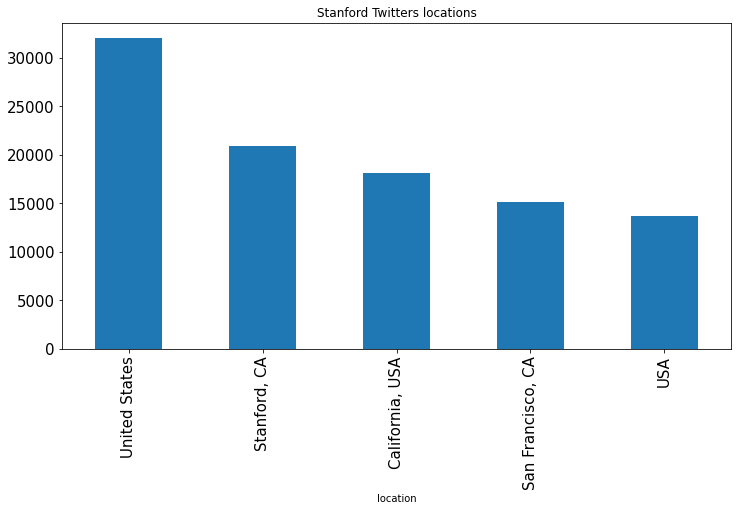

In [ ]:
#Lets try to visualize the twitterers location who is tweeting about Stanford
stanford_plot = stanford_twitterer_loc.plot(kind='bar',x='location', y='Stanford_total_twitterer_located', 
                                   legend=None, title="Stanford Twitters locations",
                                   figsize=(12,6),fontsize=15)

From the above graph output we can see that most of the tweeters location who are tweeting about Stanford belong to United states. However, this is not clear location as the location column does not have clear location mentioned. Infact, the second highest location mentioned is Stanford.

**Yale University**

In [ ]:
yale_twitterer_loc = yale_tweets.filter(col('location').isNotNull()).\
groupBy(['location']).\
agg(count('id').alias('Yale_total_twitterer_located')).\
orderBy('Yale_total_twitterer_located',ascending=False).limit(5).toPandas()

In [ ]:
yale_twitterer_loc

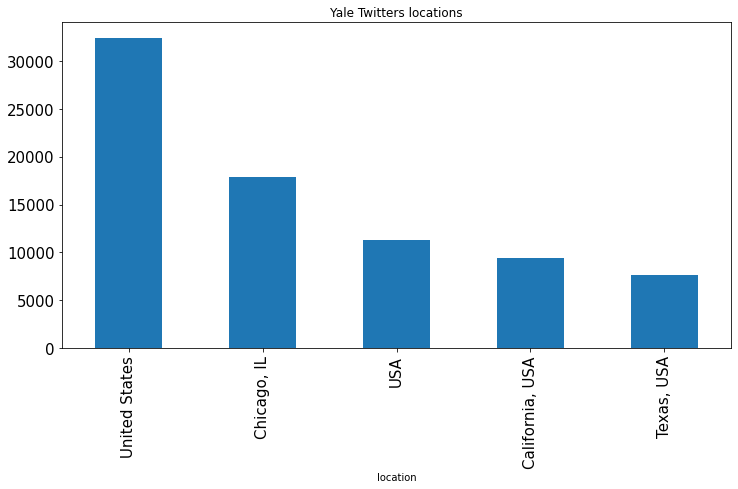

In [ ]:
#Lets try to visualize the twitterers location who is tweeting about Yale
yale_plot = yale_twitterer_loc.plot(kind='bar',x='location', y='Yale_total_twitterer_located', 
                                   legend=None, title="Yale Twitters locations",
                                   figsize=(12,6),fontsize=15)

From the above graph output we are getting some interesting result which are same as Stanford's. United states is the dominating location for the user's. This is because of the wrong data which is input in the file. Moreover, the second highest location is Chicago from where the twitteres are tweeting about Yale.

**Harvard University**

In [ ]:
harvard_twitterer_loc = harvard_tweets.filter(col('location').isNotNull()).\
groupBy(['location']).\
agg(count('id').alias('Harvard_total_twitterer_located')).\
orderBy('Harvard_total_twitterer_located',ascending=False).limit(5).toPandas()

In [ ]:
harvard_twitterer_loc

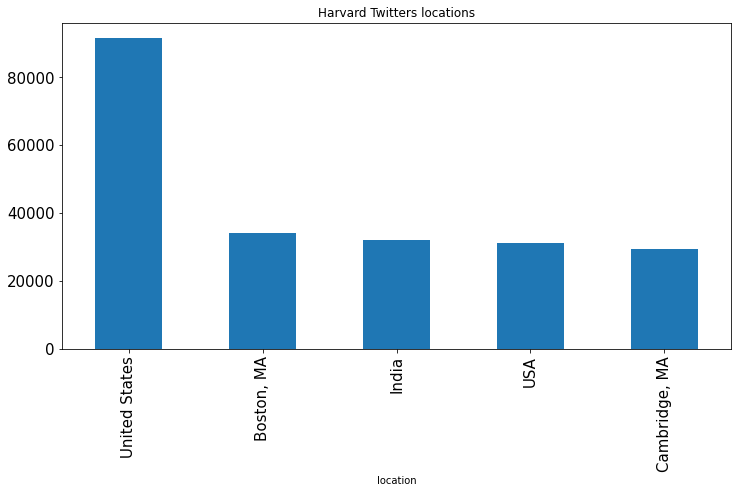

In [ ]:
#Lets try to visualize the twitterers location who is tweeting about Harvard
harvard_plot = harvard_twitterer_loc.plot(kind='bar',x='location', y='Harvard_total_twitterer_located', 
                                   legend=None, title="Harvard Twitters locations",
                                   figsize=(12,6),fontsize=15)

## What distinguishes University of Chicago Twitterers vs Twitterers who tweet about other universities  

- Visualize the trends

Looking at the limited features which we have, we can distinguish University of Chicago twitteres and twitterers who tweet about other universities by followers count and location. Above we have checked the difference based on the locations of twitterers tweeting. Here we will see based on followers count.

In [ ]:
followers_df = {'university':['UChicago','Stanford','Yale','Harvard'],
     'followers_mean_count':[Uchicago_tweets.agg(round(mean('followers_count')).cast('integer')).toPandas().iloc[0].values[0],
                                 stanford_tweets.agg(round(mean('followers_count')).cast('integer')).toPandas().iloc[0].values[0],
                                 yale_tweets.agg(round(mean('followers_count')).cast('integer')).toPandas().iloc[0].values[0],
                                 harvard_tweets.agg(round(mean('followers_count')).cast('integer')).toPandas().iloc[0].values[0]]}

In [ ]:
univ_followers_df = pd.DataFrame(data=followers_df)

In [ ]:
univ_followers_df

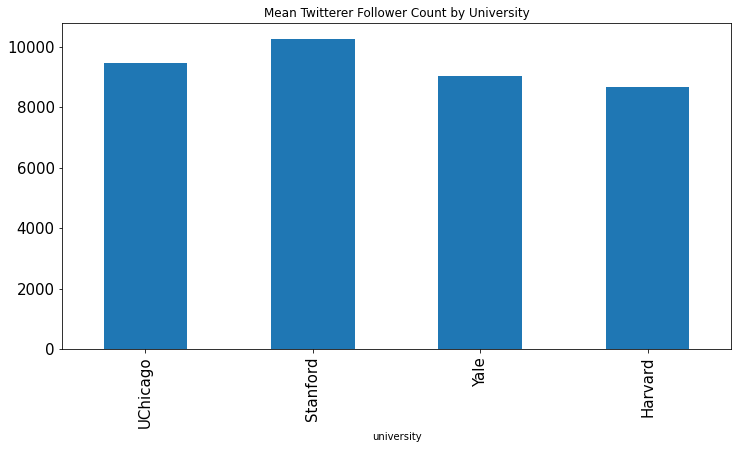

In [ ]:
followers_plot = univ_followers_df.plot(kind='bar',x='university', y='followers_mean_count', 
                                   legend=None, title="Mean Twitterer Follower Count by University",
                                   figsize=(12,6),fontsize=15)

Based on the above graph output we can see that Stanford university has the highest average mean follower count compared to other university, followed by UChicago, Yale and Harvard respectively.

## What are the timelines of these tweets? Do you see significant peaks and valleys?

- Do you see data collection gaps?

Let's first seperate the day, month and year from the created at column from the main tweet dataframe

In [17]:
day = udf(
    lambda x: x[:3]
)

month = udf(
    lambda x: x[4:7]
)

year = udf(
    lambda x: x[-4:]
)

In [18]:
tweets_timeline = tweets_new_df.withColumn('day', day(tweets_new_df.created_at)).withColumn('month', month(tweets_new_df.created_at)).withColumn('year', year(tweets_new_df.created_at))

In [ ]:
tweets_timeline.limit(3)

id,text,retweet_count,retweeted,screen_name,followers_count,location,created_at,day,month,year
851452340,@hitconsultant Un...,0,false,UXHealth,161,"New York, NY",Thu Jun 22 18:16:...,Thu,Jun,2017
152042915,Melisa Russell fi...,0,false,CubbiesCrib,2191,"Chicago, IL",Thu Jun 22 18:16:...,Thu,Jun,2017
1674589274,Chicago Quantum E...,0,false,ChuckDBrooks,5008,"Washington, DC",Thu Jun 22 18:16:...,Thu,Jun,2017


In [ ]:
# aggregating month and year together
tweet_count_timeline = tweets_timeline.groupby(['year','month']).\
agg(count('id').alias('total_tweets')).toPandas()

In [ ]:
# Segregating data for each indivdual years
tweet_timeline_2017 = tweet_count_timeline[tweet_count_timeline['year']=='2017'][['month','total_tweets']]

tweet_timeline_2018 = tweet_count_timeline[tweet_count_timeline['year']=='2018'][['month','total_tweets']]

tweet_timeline_2019 = tweet_count_timeline[tweet_count_timeline['year']=='2019'][['month','total_tweets']]

tweet_timeline_2020 = tweet_count_timeline[tweet_count_timeline['year']=='2020'][['month','total_tweets']]

Text(0, 0.5, 'Number of Tweets')

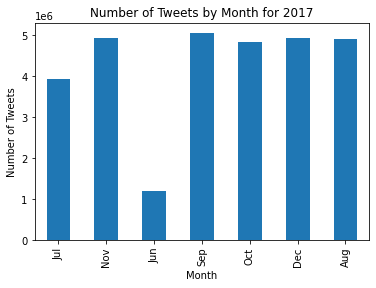

In [20]:
# plotting the results
plot_2017 = tweet_timeline_2017.plot(kind='bar',x='month',y='total_tweets',
                                        title="Number of Tweets by Month for 2017",legend=False)
plot_2017.set_xlabel('Month')
plot_2017.set_ylabel('Number of Tweets')

For the year 2017 we can see that tweets have not been tweeted for the entire year. We have the tweets from July-Dec month only. Highest tweets for the year 2017 has been tweeted for September month and the lowest for the month June. Also, the tweets are been made during the Fall period August - December.

Text(0, 0.5, 'Number of Tweets')

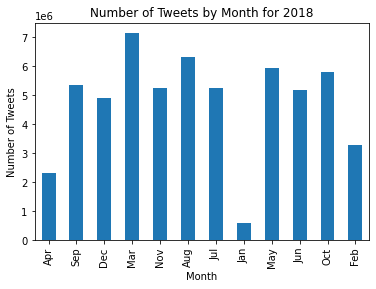

In [21]:
# plotting the results
plot_2018 = tweet_timeline_2018.plot(kind='bar',x='month',y='total_tweets',
                                        title="Number of Tweets by Month for 2018",legend=False)
plot_2018.set_xlabel('Month')
plot_2018.set_ylabel('Number of Tweets')

For the year 2018 we have the tweets for the entire year. By the above graph we can see that Highest tweets are been made in the month of March and the lowest in the month of January. Again during the fall period we can see that twitterers are consistantly active.

Text(0, 0.5, 'Number of Tweets')

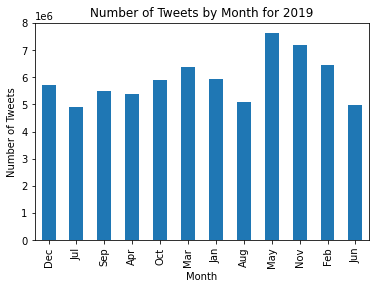

In [22]:
# plotting the results
plot_2019 = tweet_timeline_2019.plot(kind='bar',x='month',y='total_tweets',
                                        title="Number of Tweets by Month for 2019",legend=False)
plot_2019.set_xlabel('Month')
plot_2019.set_ylabel('Number of Tweets')

For the year 2019 we have the tweets for the entire year. Highest tweets have been made in the month of May. The twittereres have been consistantly active and twitting for the entire year.

Text(0, 0.5, 'Number of Tweets')

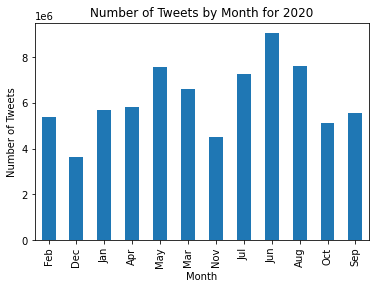

In [23]:
# plotting the results
plot_2020 = tweet_timeline_2020.plot(kind='bar',x='month',y='total_tweets',
                                        title="Number of Tweets by Month for 2020",legend=False)
plot_2020.set_xlabel('Month')
plot_2020.set_ylabel('Number of Tweets')

rom the above graph we can see that for the year 2020 highest tweets have been made in the month of June and the lowest in Dec. In the summer period we have seen from 2018, 2019 and 2020 graph highest tweets are been made during Summer months which may be because its the break period.

## How unique are the messages for each of these universities?  

- Are they mostly unique? Or mostly people are just copy-pasting the same text?
- You can use something like Jaccard similarity / Cosine Similarity / Simhash / Minhash to measure uniqueness / similarity
- Visualize message duplication (for each university – not between the universities)
- Please note: this is not a topic modeling (LDA / LSA) – but text similarity analysis.  

We will use **Minhash LSH** to measure similarity of texts

In [24]:
#Considering only 10K datapoints for this activity
Uchicago_tweets_texts = Uchicago_tweets.select(['text']).limit(10000)

In [26]:
# Clean the data by emoving stopwords
text = Uchicago_tweets_texts.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()

In [ ]:
# creating the index
row = Row('text')
Uchicago_tweets_texts = text.map(row).zipWithIndex().toDF(['text','id'])

In [ ]:
# creating the dataframe with text and id
UChicago_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])

# Drop records with no tokens
UChicago_tokens = UChicago_tokens.where(col('list_of_words').getItem(0).isNotNull())

In [ ]:
# creating the countvectorizer features
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
UChicago_vectorize = vectorize.fit(UChicago_tokens).transform(UChicago_tokens)

In [ ]:
# creating hash table
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model1 = mh.fit(UChicago_vectorize)
UChicago_hashed = mh.fit(UChicago_vectorize).transform(UChicago_vectorize)

# joining the hashed table with normal table
UChicago_hashed_text = Uchicago_tweets_texts.join(UChicago_hashed, "id", how = 'left')

In [ ]:
# setting a low Jaccard distance of 0.3
jaccard_distance = 0.3

# joining dataframe with itself
UChicago_dups_text = model1.approxSimilarityJoin(UChicago_hashed_text, UChicago_hashed_text, jaccard_distance).\
filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B')
            )

In [ ]:
# checking first few near duplicate tweets
UChicago_dups_text.limit(5).toPandas()

,distCol,id_A,id_B,text_A,text_B
0,0.0,5699,5700,{'text': 'RT @nonexpedit: EscortForum is the new Master at University of Chicago.'},{'text': 'MBB: Follow along with tonight's action as the CMS takes on the University of Chicago at 7:30 pm: Live Stats:… https://t.co/A8kKMgFe5t'}
1,0.0,5426,5430,{'text': '.@UChicago spin-out startup NowPow aims to improve ‘whole person care’ https://t.co/PPpYHxHH2s'},{'text': 'We at @uchicagogsu should heed @uicgeo demands (&amp; wins) for financial support for international graduate students.… https://t.co/AggmbkqmOH'}
2,0.0,5428,5433,{'text': 'RT @Destiny3650: DOES NOT SURPRISE ME! When Michael was an associate dean at University of Chicago she organized a panel discussion featuri…'},{'text': 'RT @Destiny3650: DOES NOT SURPRISE ME! When Michael was an associate dean at University of Chicago she organized a panel discussion featuri…'}
3,0.0,6472,6484,"{'text': 'Says: Contract Tracer at NORC at the University of Chicago in Cumberland, MD is for you! Apply:… https://t.co/t44SJH6HCA'}",{'text': 'RT @AmySchwartzNY: @mattkahn1966 @Austan_Goolsbee @UChicago FWIW - my daughter is a Booth prof. Funny and wonderful how life happens... b…'}
4,0.0,6468,6479,{'text': 'RT @vishj05: Raghuram Rajan is Professor of Finance at University of Chicago. He was Director of Research at International Monetory Fund.…'},"{'text': 'RT @MHendricksonCST: Hundreds refuse to pay UChicago as tuition strike takes off, organizers say: ‘This isn’t a bluff’ https://t.co/sFGy4XJ…'}"


In [ ]:
# checking the number of uniques and duplicates
records = UChicago_hashed_text.count()
dups = UChicago_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total tweets: ', records)
print ('Duplicate tweets based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique tweets based on {', jaccard_distance, '} jaccard distance: ', uniques)

Total tweets:  10000
Duplicate tweets based on { 0.3 } jaccard distance:  4795
Unique tweets based on { 0.3 } jaccard distance:  5205


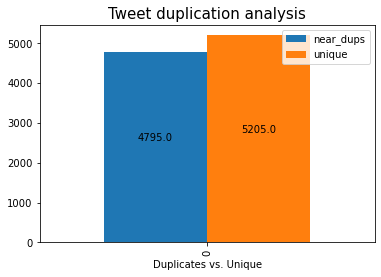

In [ ]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})
ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8)
ax.set_title('Tweet duplication analysis', fontsize=15)
ax.set_xlabel('Duplicates vs. Unique')
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

From the above graph we can see with Jaccard score of 0.3 has produced quite a good results in terms of predicting near duplicate texts. Now we will proceed to check the similarity for each University

### Stanford University

In [35]:
stanford_tweets_text = stanford_tweets.select(['text']).limit(10000)

In [36]:
# removing the stopwords
text = stanford_tweets_text.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()

In [ ]:
# creating the index
row = Row('text')
stanford_tweets_text = text.map(row).zipWithIndex().toDF(['text','id'])

In [ ]:
# creating the dataframe with text and id
stanford_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])

# Drop records with no tokens
stanford_tokens = stanford_tokens.where(col('list_of_words').getItem(0).isNotNull())

In [ ]:
# creating the vectorizer features
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
stanford_vectorize = vectorize.fit(stanford_tokens).transform(stanford_tokens)

In [ ]:
# creating hash table
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model2 = mh.fit(stanford_vectorize)
stanford_hashed = mh.fit(stanford_vectorize).transform(stanford_vectorize)

# joining the hashed table with normal table
stanford_hashed = stanford_tweets_text.join(stanford_hashed, "id", how = 'left')

In [ ]:
# setting a low Jaccard distance of 0.3
jaccard_distance = 0.3

# joining dataframe with itself
stanford_dups_text = model2.approxSimilarityJoin(stanford_hashed, stanford_hashed, jaccard_distance).\
filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B')
            )

In [ ]:
# checking the number of uniques and duplicates
records = stanford_hashed.count()
dups = stanford_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total tweets: ', records)
print ('Duplicate tweets based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique tweets based on {', jaccard_distance, '} jaccard distance: ', uniques)

Total tweets:  10000
Duplicate tweets based on { 0.3 } jaccard distance:  5721
Unique tweets based on { 0.3 } jaccard distance:  4279


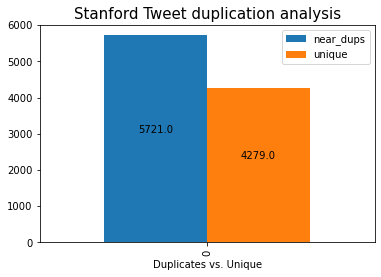

In [ ]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8)
ax.set_title('Stanford Tweet duplication analysis', fontsize=15)
ax.set_xlabel('Duplicates vs. Unique')
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

As we can see from the above graph output for Stanford university we have more duplicate records then the unique ones which means people are retweeting the same tweets and sharing unique tweets less.

### Yale University

In [19]:
yale_tweets_text = yale_tweets.select(['text']).limit(10000)

In [20]:
# removing the stopwords
text = yale_tweets_text.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()

In [ ]:
# creating the index
row = Row('text')
yale_tweets_text = text.map(row).zipWithIndex().toDF(['text','id'])

In [ ]:
# creating the dataframe with text and id
yale_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])

# Drop records with no tokens
yale_tokens = yale_tokens.where(col('list_of_words').getItem(0).isNotNull())

In [ ]:
# creating the vectorizer features
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
yale_vectorize = vectorize.fit(yale_tokens).transform(yale_tokens)

In [ ]:
# creating hash table
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model2 = mh.fit(yale_vectorize)
yale_hashed = mh.fit(yale_vectorize).transform(yale_vectorize)

# joining the hashed table with normal table
yale_hashed = yale_tweets_text.join(yale_hashed, "id", how = 'left')

In [ ]:
# setting a low Jaccard distance of 0.3
jaccard_distance = 0.3

# joining dataframe with itself
yale_dups_text = model2.approxSimilarityJoin(yale_hashed, yale_hashed, jaccard_distance).\
filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B')
            )

In [ ]:
# checking the number of uniques and duplicates
records = yale_hashed.count()
dups = yale_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total tweets: ', records)
print ('Duplicate tweets based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique tweets based on {', jaccard_distance, '} jaccard distance: ', uniques)

Total tweets:  10000
Duplicate tweets based on { 0.3 } jaccard distance:  6189
Unique tweets based on { 0.3 } jaccard distance:  3811


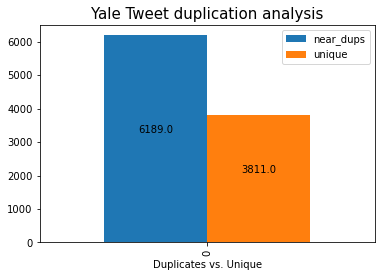

In [29]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8)
ax.set_title('Yale Tweet duplication analysis', fontsize=15)
ax.set_xlabel('Duplicates vs. Unique')
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

From the above graph we can see that for Yale duplicate tweets are more in number compared to the unique ones which again means that more twetters are retweeting regarding Yale

### Harvard University

In [30]:
harvard_tweets_text = harvard_tweets.select(['text']).limit(10000)

In [31]:
# removing the stopwords
text = harvard_tweets_text.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()

In [ ]:
# creating the index
row = Row('text')
harvard_tweets_text = text.map(row).zipWithIndex().toDF(['text','id'])

In [ ]:
# creating the dataframe with text and id
harvard_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])

# Drop records with no tokens
harvard_tokens = harvard_tokens.where(col('list_of_words').getItem(0).isNotNull())

In [ ]:
# creating the vectorizer features
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
harvard_vectorize = vectorize.fit(harvard_tokens).transform(harvard_tokens)

In [ ]:
# creating hash table
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model2 = mh.fit(harvard_vectorize)
harvard_hashed = mh.fit(harvard_vectorize).transform(harvard_vectorize)

# joining the hashed table with normal table
harvard_hashed = harvard_tweets_text.join(harvard_hashed, "id", how = 'left')

In [ ]:
# setting a low Jaccard distance of 0.3
jaccard_distance = 0.3

# joining dataframe with itself
harvard_dups_text = model2.approxSimilarityJoin(harvard_hashed, harvard_hashed, jaccard_distance).\
filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B')
            )

In [ ]:
# checking the number of uniques and duplicates
records = harvard_hashed.count()
dups = harvard_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total tweets: ', records)
print ('Duplicate tweets based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique tweets based on {', jaccard_distance, '} jaccard distance: ', uniques)

Total tweets:  10000
Duplicate tweets based on { 0.3 } jaccard distance:  2448
Unique tweets based on { 0.3 } jaccard distance:  7552


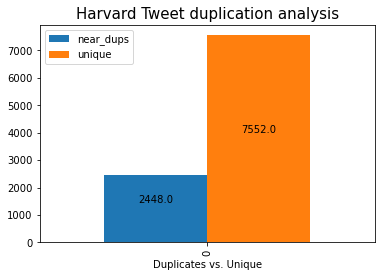

In [ ]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8)
ax.set_title('Harvard Tweet duplication analysis', fontsize=15)
ax.set_xlabel('Duplicates vs. Unique')
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 